In [1]:
import os

from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = './lmdb'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

# Simple CNN baseline

pytorch and lmdb are required for this baseline implementation

## Baseline method

- Naively resize to 32x32 (DON'T DO THIS IN YOUR WORK, try to save geometry somehow, it is important)
- Train LeNet-like CNN
- Enjoy :)

In [2]:
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter

import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

/home/tokyo-jazz/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tokyo-jazz/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/tokyo-jazz/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more ab

### Data tools

In [4]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [5]:
train_helper, val_helper = train_helper.train_val_split()
train_helper.size(), val_helper.size()

(2578433, 644609)

In [6]:
class ToSquare(nn.Module):
    def forward(self, img):
        h, w = img.shape
        return np.pad(
            img, 
            (
                (
                    max(0, (w - h) // 2),
                    max(0, (w - h + 1) // 2)
                ),
                (
                    max(0, (h - w) // 2),
                    max(0, (h - w + 1) // 2)
                )
            ),
            constant_values=255
        )


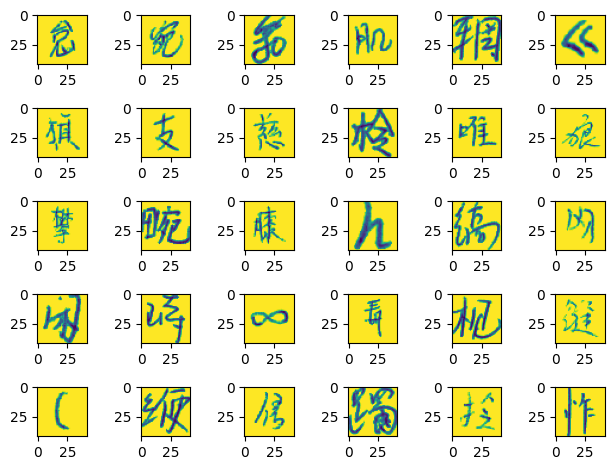

In [10]:
f, axarr = plt.subplots(5,6) 

for i in range(5):
    for j in range(6):
        idx = 50 + i * 6 + j
        img, label = train_helper.get_item(idx)
        img = ToSquare()(img)
        img = cv2.resize(img, (42, 42))
        axarr[i, j].imshow(img)

plt.tight_layout()
plt.show()

In [7]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        img = ToSquare()(img)
        img = cv2.resize(img, (32, 32))
        img = (img - 127.5) / 255
        return img, label

In [12]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

### Model & training

In [8]:
from rescosface import ResCosFace

In [14]:
model = ResCosFace(train_helper.vocabulary.num_classes(), 1024)
model.eval()

ResCosFace(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [15]:
def get_cosface_loss(s=64., margin=0.35):
    def cosface_loss(logits, targets):
        mask = F.one_hot(targets, num_classes=train_helper.vocabulary.num_classes()).bool()
        margined_logits = torch.where(
            mask,
            logits - margin,
            logits
        )
        margined_logits *= s
        return nn.CrossEntropyLoss()(margined_logits, targets)
    return cosface_loss

In [16]:
assert torch.cuda.is_available()
device = torch.device('cuda')

model = model.to(device)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)

In [19]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = get_cosface_loss()

In [43]:
import gc
torch.cuda.empty_cache()
gc.collect()

3383

In [20]:
tb = SummaryWriter()

def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.unsqueeze(1).to(torch.float32).to(device))
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).to(device))
        loss = loss_fn(logits, y.to(torch.long).to(device))
        
        if batch % 100 == 0:
            tb.add_scalar("losses/train_loss", loss, global_step=epoch*len(train_loader)+batch)
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            acc = sum(classes == y.cpu().numpy()) / len(classes)
            tb.add_scalar("losses/train_acc", acc, global_step=epoch*len(train_loader)+batch)
        
        optim.zero_grad()
        loss.backward()
        optim.step()


for epoch in range(100):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'res18cosface-0305_epoch{epoch}.pth')

Epoch 0:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:04<00:00, 27.36it/s]


accuracy: 0.8947020596982046
Epoch 1:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:05<00:00, 27.09it/s]


accuracy: 0.9348535313655254
Epoch 2:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:06<00:00, 27.05it/s]


accuracy: 0.941531998467288
Epoch 3:


 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                        | 9170/20144 [19:21<23:07,  7.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:08<00:00, 26.70it/s]


accuracy: 0.9503962867412649
Epoch 17:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:08<00:00, 26.76it/s]


accuracy: 0.9505777921189434
Epoch 18:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:07<00:00, 26.88it/s]


accuracy: 0.9512851976934855
Epoch 19:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5037/5037 [03:16<00:00, 25.69it/s]


accuracy: 0.9512774410534138
Epoch 20:


  0%|▍                                                                                                                                                                   | 60/20144 [00:08<45:30,  7.36it/s]


KeyboardInterrupt: 

### Evaluation

In [9]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [10]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

In [11]:
device = torch.device('cuda')
model = ResCosFace(train_helper.vocabulary.num_classes(), 1024)
model.load_state_dict(torch.load("checkpoints/res18cosface-0305_epoch19.pth"))
model.to(device)

ResCosFace(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [12]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6067/6067 [03:38<00:00, 27.78it/s]


In [13]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [14]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9400764690807613